In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import json
import requests

import wrangle
import prepare as prep

from env import github_token, github_username

from wordcloud import WordCloud

import re
import unicodedata
import nltk

## Acquire and Prep

In [2]:
df = pd.read_json("data.json")
df.head()

,repo,language,readme_contents
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...
2,sychi77/Thoracic_Surgery_Patient_Survival,Jupyter Notebook,# Thoracic Surgery for Lung Cancer Data Set\n ...
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Jupyter Notebook,# HackerRank Data Scientist Hiring Test: Predi...
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             166 non-null    object
 1   language         157 non-null    object
 2   readme_contents  166 non-null    object
dtypes: object(3)
memory usage: 4.0+ KB


In [4]:
df = prep.prep_data(df)
df.head()

,repo,language,original,clean,more_clean
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid 19 prov...,reduction life expectancy brazil covid 19 prov...
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,animated annual changes life expectancy illust...,animated annual change life expectancy illustr...
2,sychi77/Thoracic_Surgery_Patient_Survival,Jupyter Notebook,# Thoracic Surgery for Lung Cancer Data Set\n ...,thoracic surgery lung cancer data set uci mach...,thoracic surgery lung cancer data set uci mach...
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Jupyter Notebook,# HackerRank Data Scientist Hiring Test: Predi...,hackerrank data scientist hiring test predict ...,hackerrank data scientist hiring test predict ...
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",p align center img src https github com oxford...,p align center img src http github com oxfordd...


In [5]:
df.language.value_counts()

other               65
Jupyter Notebook    48
R                   31
HTML                22
Name: language, dtype: int64

In [6]:
df_no_jupyter = prep.prep_data(df, remove_jupyter=True)

In [7]:
df_no_jupyter.head()

,repo,language,original,clean,more_clean
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid 19 prov...,reduction life expectancy brazil covid 19 prov...
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,animated annual changes life expectancy illust...,animated annual change life expectancy illustr...
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",p align center img src https github com oxford...,p align center img src http github com oxfordd...
5,hemanth/life-expectancy,other,# life-expectancy [![Build Status](https://tra...,life expectancy build status https travis ci o...,life expectancy build status http travis ci or...
6,libre-money-projects/Geconomicus,other,# Ğeconomicus\nĞeconomicus is a generic free e...,geconomicus geconomicus generic free economic ...,geconomicus geconomicus generic free economic ...


In [8]:
df_no_jupyter.language.value_counts()

other    65
R        31
HTML     22
Name: language, dtype: int64

## Explore 
#### Pre-Processing

In [9]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "language")

,n,percent
other,65,0.391566
Jupyter Notebook,48,0.289157
R,31,0.186747
HTML,22,0.132530


In [10]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [11]:
## Create lists of words for each language category
other = clean(' '.join(df[df.language == 'other'].original))
jupyter = clean(' '.join(df[df.language == 'Jupyter Notebook'].original))
r = clean(' '.join(df[df.language == 'R'].original))
html = clean(' '.join(df[df.language == 'HTML'].original))
all_words = clean(' '.join(df.original))

In [13]:
## Transform lists into series
other_freq = pd.Series(other).value_counts()
jupyter_freq = pd.Series(jupyter).value_counts()
r_freq = pd.Series(r).value_counts()
html_freq = pd.Series(html).value_counts()
all_freq = pd.Series(all_words).value_counts()

other_freq.head()

data          150
life          137
feature       134
expectancy    127
country        90
dtype: int64

In [15]:
#Create a word_counts data frame we can work with

word_counts = (pd.concat([all_freq, other_freq, jupyter_freq, r_freq, html_freq], axis=1, sort=True)
                .set_axis(['all', 'other', 'jupyter', 'r', 'html'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,other,jupyter,r,html
0,37,7,20,10,0
000,2,0,2,0,0
00002696875,1,0,0,1,0
00002847784,1,0,0,1,0
00002848100,1,0,0,1,0


### Answer questions about word frequency:

**What are the most frequently occuring words?**

In [16]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,other,jupyter,r,html
life,444,137,124,137,46
data,428,150,95,164,19
expectancy,406,127,116,119,44
country,237,90,84,49,14
year,209,82,41,74,12
model,165,35,40,87,3
feature,165,134,29,0,2
file,156,83,8,40,25
1,121,60,26,32,3
project,118,60,33,10,15


**Are there any words that uniquely identify one of the coding languages?**

In [17]:
pd.concat([word_counts[word_counts.other == 0].sort_values(by='other').tail(6),
           word_counts[word_counts.jupyter == 0].sort_values(by='jupyter').tail(6),
           word_counts[word_counts.r == 0].sort_values(by='r').tail(6),
           word_counts[word_counts.html == 0].sort_values(by='html').tail(6)])

,all,other,jupyter,r,html
deal,1,0,1,0,0
death_1yr,1,0,1,0,0
deathsnumber,3,0,2,1,0
deathspoliothinness_1to19_yrsgdp,1,0,0,1,0
dautonomie,1,0,0,1,0
zubrod,1,0,1,0,0
disparity,1,0,0,0,1
displaying,1,1,0,0,0
disproportionately,1,1,0,0,0
distance,4,4,0,0,0


Text(0.5, 1.0, 'Proportion of Language Word Frequency for the 20 most common words')

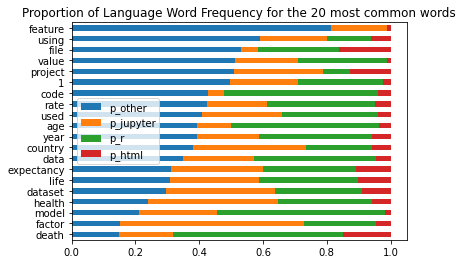

In [18]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_other=word_counts.other / word_counts['all'],
         p_jupyter=word_counts.jupyter / word_counts['all'],
         p_r=word_counts.r / word_counts['all'],
         p_html=word_counts.html / word_counts['all'])
 .sort_values(by='all')
 [['p_other', 'p_jupyter', 'p_r', 'p_html']]
 .tail(20)
 .sort_values('p_other')
 .plot.barh(stacked=True))

plt.title('Proportion of Language Word Frequency for the 20 most common words')


### Create and Visualize Bigrams

In [29]:
# Top 20 other
top_20_other_bigrams = (pd.Series(nltk.ngrams(other, 2))
                      .value_counts()
                      .head(20))

top_20_other_bigrams.head()

(life, expectancy)    126
(sex, age)             15
(expectancy, sex)      14
(age, income)          12
(survival, rate)       12
dtype: int64

In [30]:
# Top 20 jupyter 
top_20_jupyter_bigrams = (pd.Series(nltk.ngrams(jupyter, 2))
                      .value_counts()
                      .head(20))

top_20_jupyter_bigrams.head()

(life, expectancy)     115
(machine, learning)     19
(per, caput)            12
(predict, life)         11
(f, 0)                  11
dtype: int64

In [24]:
# Top 20 r
top_20_r_bigrams = (pd.Series(nltk.ngrams(r, 2))
                      .value_counts()
                      .head(20))

top_20_r_bigrams.head()

(life, expectancy)        118
(data, type)               21
(specie, standardised)     14
(income, composition)      14
(standardised, iucn)       13
dtype: int64

In [28]:
# Top 20 html
top_20_html_bigrams = (pd.Series(nltk.ngrams(html, 2))
                      .value_counts()
                      .head(20))

top_20_html_bigrams.head()

(life, expectancy)    44
(rmd, file)           14
(mean, median)        10
(median, survival)     8
(per, caput)           7
dtype: int64

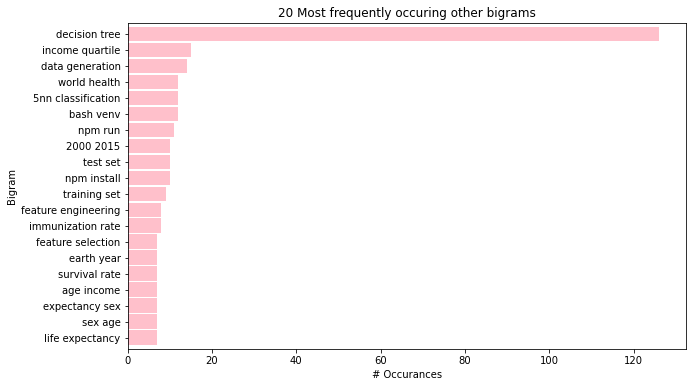

In [31]:
## Plot Top 20 Other

top_20_other_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring other bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_other_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


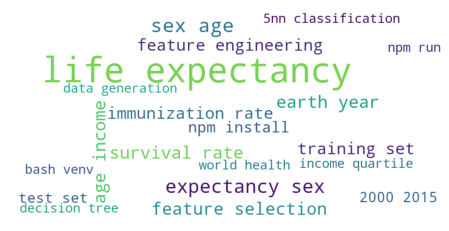

In [38]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_other_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

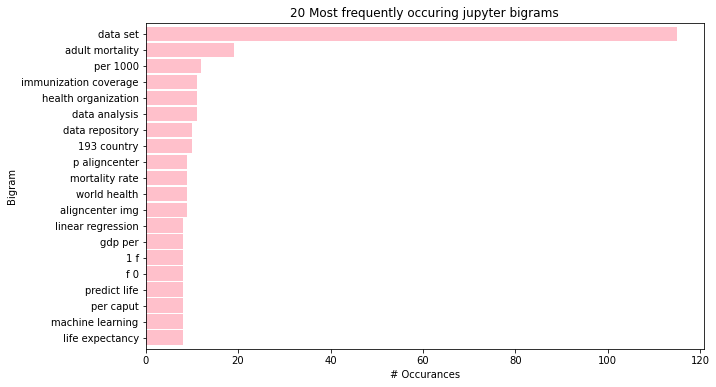

In [32]:
## Plot Top 20 jupyter

top_20_jupyter_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring jupyter bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_jupyter_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


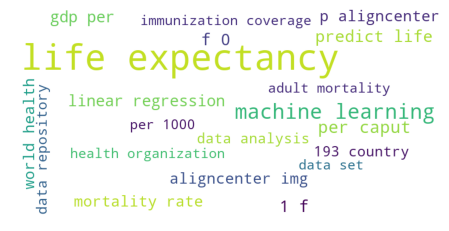

In [39]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_jupyter_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

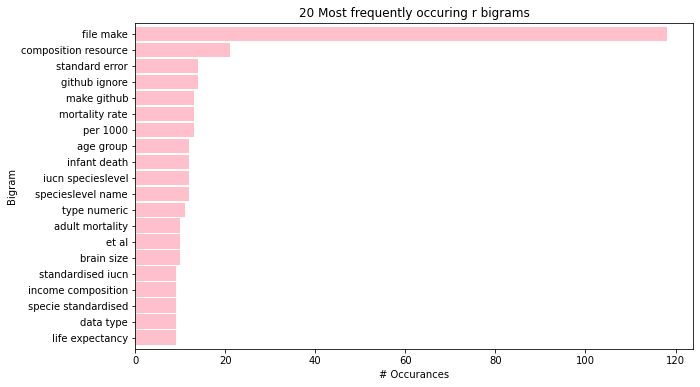

In [34]:
## Plot Top 20 r

top_20_r_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring r bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_r_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

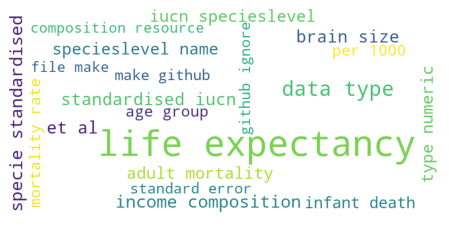

In [40]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_r_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

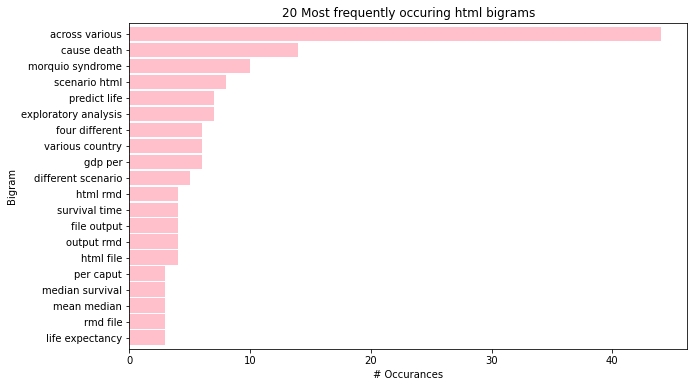

In [42]:
## Plot Top 20 html

top_20_html_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring html bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_html_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

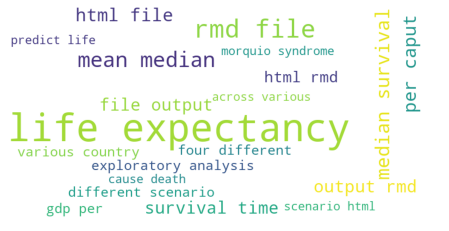

In [41]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_html_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Add Other Features to Explore